<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания, работающая на пассажирских перевозок, собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки. Необходимо спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Требования:
 - Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Техническое задание:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


## Подготовка

In [1]:
pip install -q catboost

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

In [3]:
# Устанавливаем новые стандартные размеры граффиков по проекту
plt.rcParams["figure.figsize"] = (15,10)

In [4]:
pth1 = 'D:/Python/datasets/taxi.csv'
pth2 = 'taxi.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong', index_col=[0], parse_dates=[0])

Первичный осмотр данных

In [5]:
print(data.info())
data.head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


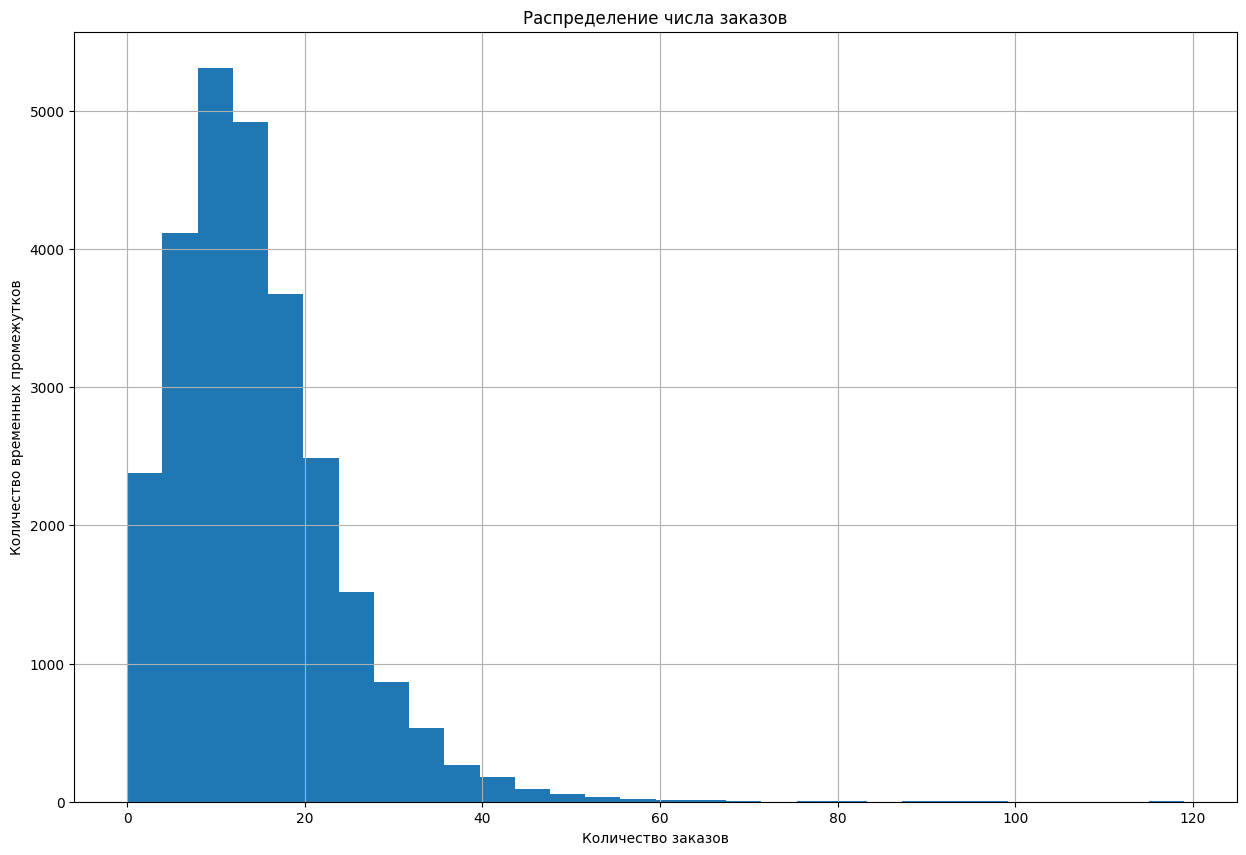

In [6]:
data.hist(bins=30)
plt.title('Распределение числа заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Количество временных промежутков');

Изучим данные. Набор состоит из одного целевого признака `num_orders` и содержит 26496 значений. Распределение значений напоминает распределение Пуассона, так как данные представляют собой количество заказов за 10 минут. Выбросов и ошибочных значений не зарегистрированно. Можно дальше продолжить анализ с полными данными.

## Анализ

Проверим данные на монохромность и перестроим орядок в случае её отсутствия.

In [7]:
if data.index.is_monotonic == True:
    print('Данные монохромные')
else:
    data.sort_index(inplace=True)

Данные монохромные


<ipython-input-7-78ac4d75a7b4>:1: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if data.index.is_monotonic == True:


Обратим внимание за какой промежуток мы имеем данные.

In [8]:
print('Изучаемый промежуток времени с ', data.index.min(), 'по', data.index.max())

Изучаемый промежуток времени с  2018-03-01 00:00:00 по 2018-08-31 23:50:00


Так как нам необходимо предсказать количество заказов в следующий час, переразобъём данные по часам, суммируя данные между.

In [9]:
data = data.resample('1H').sum()

Так как мы имеем данные за 6 месяцев и наша задача состоит прогнозировании количество заказов такси на следующий час, то произведём ресемплирование данных по часам и оценим тренд и сезонность. Однако, поскольку общий интервал данных *(6 месяцев)* значительно превышает интервал предсказаний *(1 час)*, то чтобы избежать высокой частоты изменений и оценить общий тренд оценим его разбив данные по дням и используя среднее количество заказов в час.

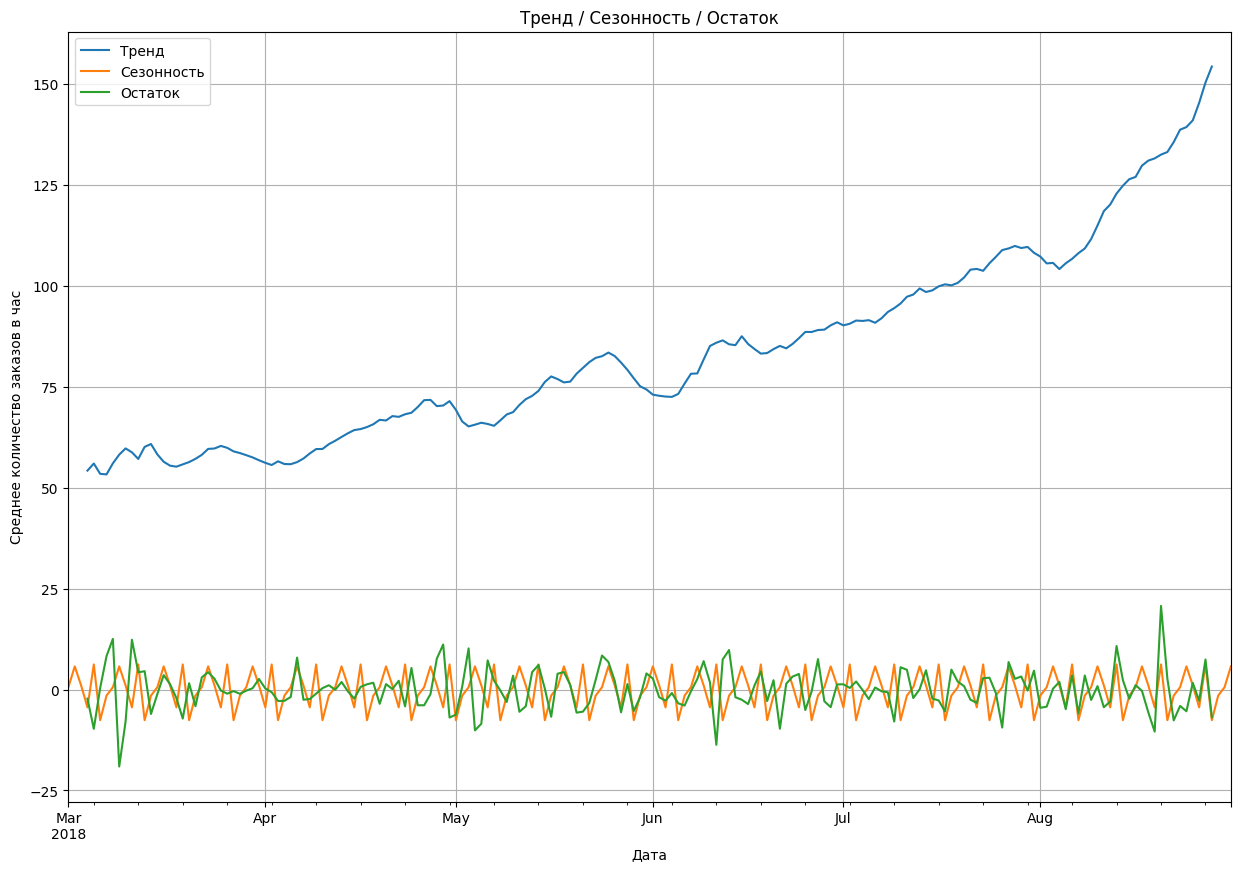

In [10]:
decomposed = seasonal_decompose(data.resample('1D').mean())
decomposed.trend.plot(ax=plt.gca())
decomposed.seasonal.plot(ax=plt.gca())
decomposed.resid.plot(ax=plt.gca())
plt.legend(['Тренд', 'Сезонность', 'Остаток'])
plt.title('Тренд / Сезонность / Остаток')
plt.ylabel('Среднее количество заказов в час')
plt.xlabel('Дата')
plt.grid(True);

Получаем нарастающий тренд и найденную сезонность. Необходимо изучить её периодичность и создать параметр на основе периода сезонности.

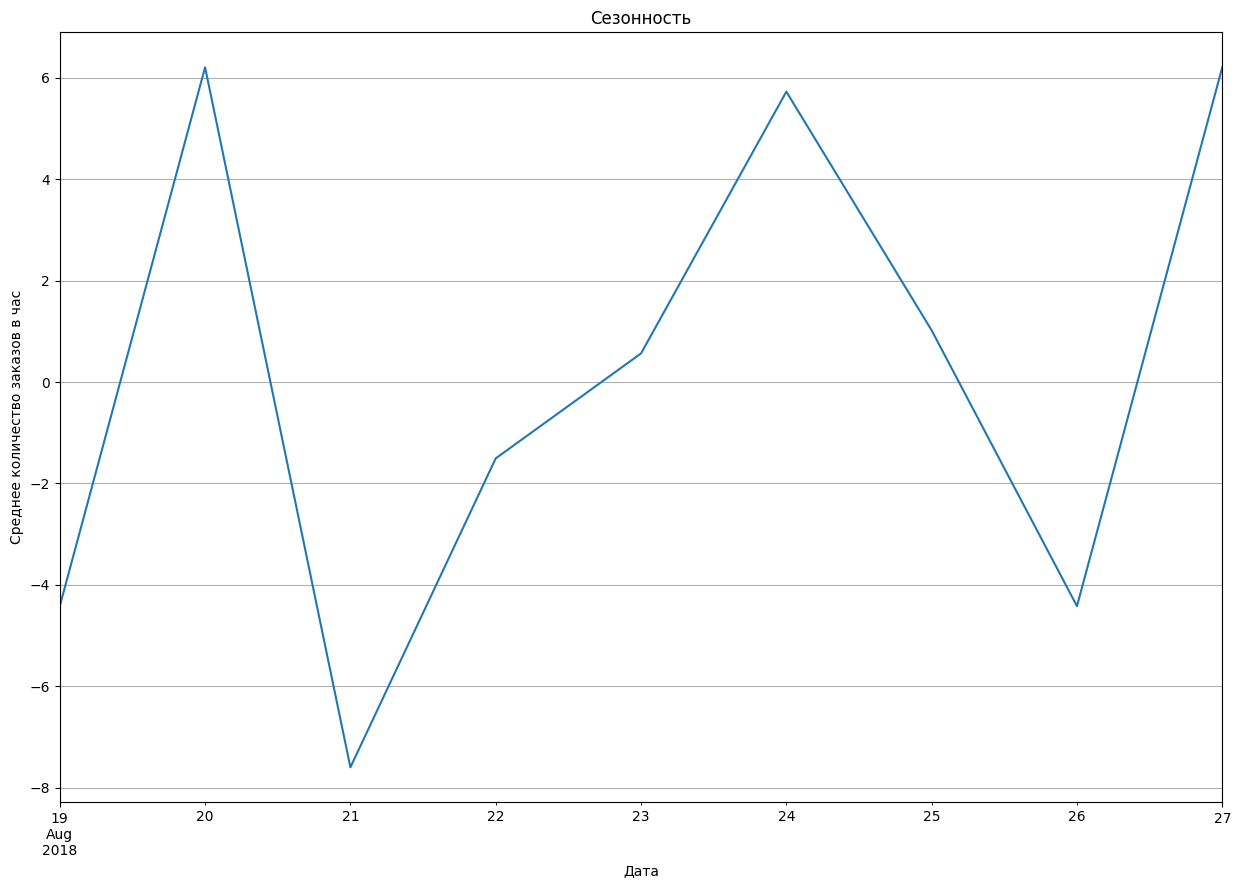

In [11]:
decomposed.seasonal.loc['2018-08-19':'2018-08-27'].plot(ax=plt.gca());
plt.title('Сезонность')
plt.ylabel('Среднее количество заказов в час')
plt.xlabel('Дата')
plt.grid(True);

Как видно из визуализации, период сезонности составляет порядка 7 дней. Стоит изучить зависимость среднего количества заказов в час от дня недели. А так же изучить распределение количества заказов в час от времени суток.

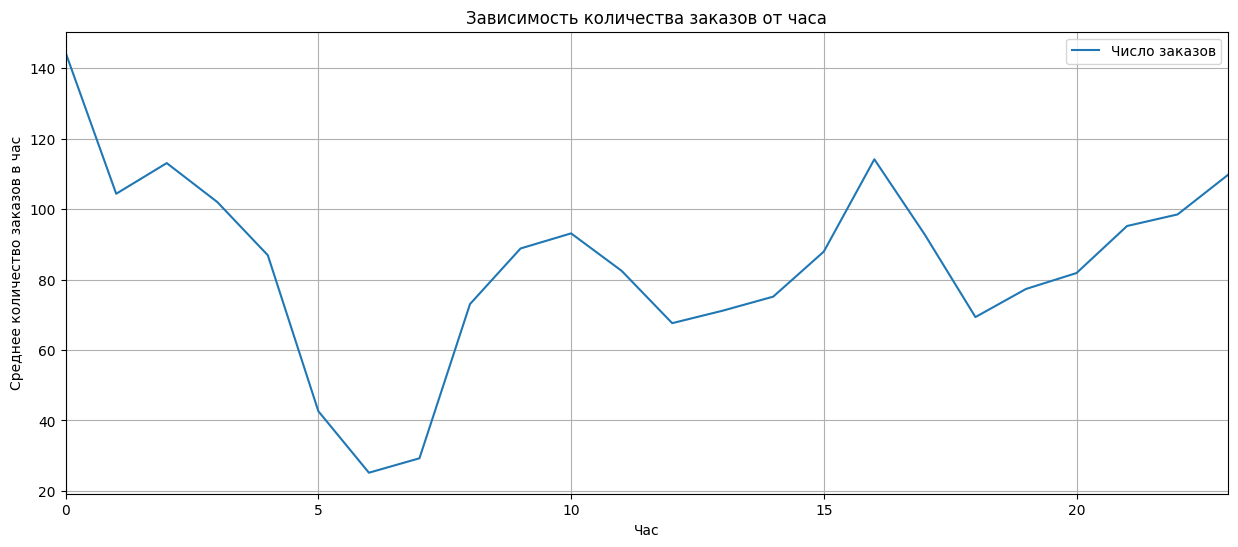

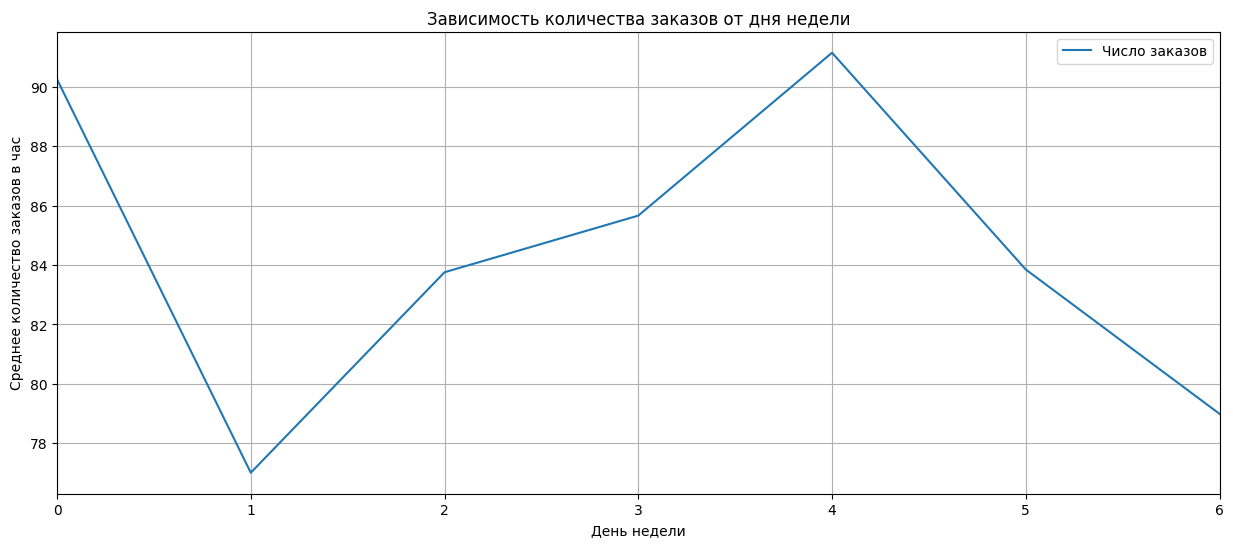

In [12]:
data.groupby(data.index.hour).mean().plot(figsize=(15, 6))
plt.xlim(0, 23)
plt.legend(['Число заказов'])
plt.title('Зависимость количества заказов от часа')
plt.ylabel('Среднее количество заказов в час')
plt.xlabel('Час')
plt.grid(True)
data.groupby(data.index.dayofweek).mean().plot(figsize=(15, 6))
plt.xlim(0, 6)
plt.title('Зависимость количества заказов от дня недели')
plt.ylabel('Среднее количество заказов в час')
plt.xlabel('День недели')
plt.legend(['Число заказов'])
plt.grid(True);

Теперь становится очевидно, что сезонность привязана ко дню недели, в понедельник и пятницу наибольшее количество заказов, тогда как во вторник и воскресенье наименьшее. Тоже самое касается времени суток. Наибольшее число заказов ночью после ***20 и до 4***, в утреннее время ***с 8 до 11*** и дневное ***с 14 до 18***. Поскольку наша задача о заказах такси в аэропортах то теперь очевидно, что тренд роста к лету вероятно связан с летними и осенними отпусками. Так же сезонность понедельника и пятницы объясняется тем, что отпуск часто для начала отпуска выбрают понедельник, поэтому прелёты более активны после рабочего дня в пятницу, на выходных или в понедельник. Однако на выходных больше времени и возможности добраьться на другом транспорте. Поэтому в субботу и воскресенье спрос на такси снижен, тогда как в понедельник и пятницу наблюдается повышение. Тоже касается времени. Наиболее популярны ночные, вечерние или дневные перелёты. Чтобы получить более точную модель стоит добавить признаки: день недели и час.

Оценим общий тренд и способ его находжения. Для этого построим среднее скользящее за неделю.

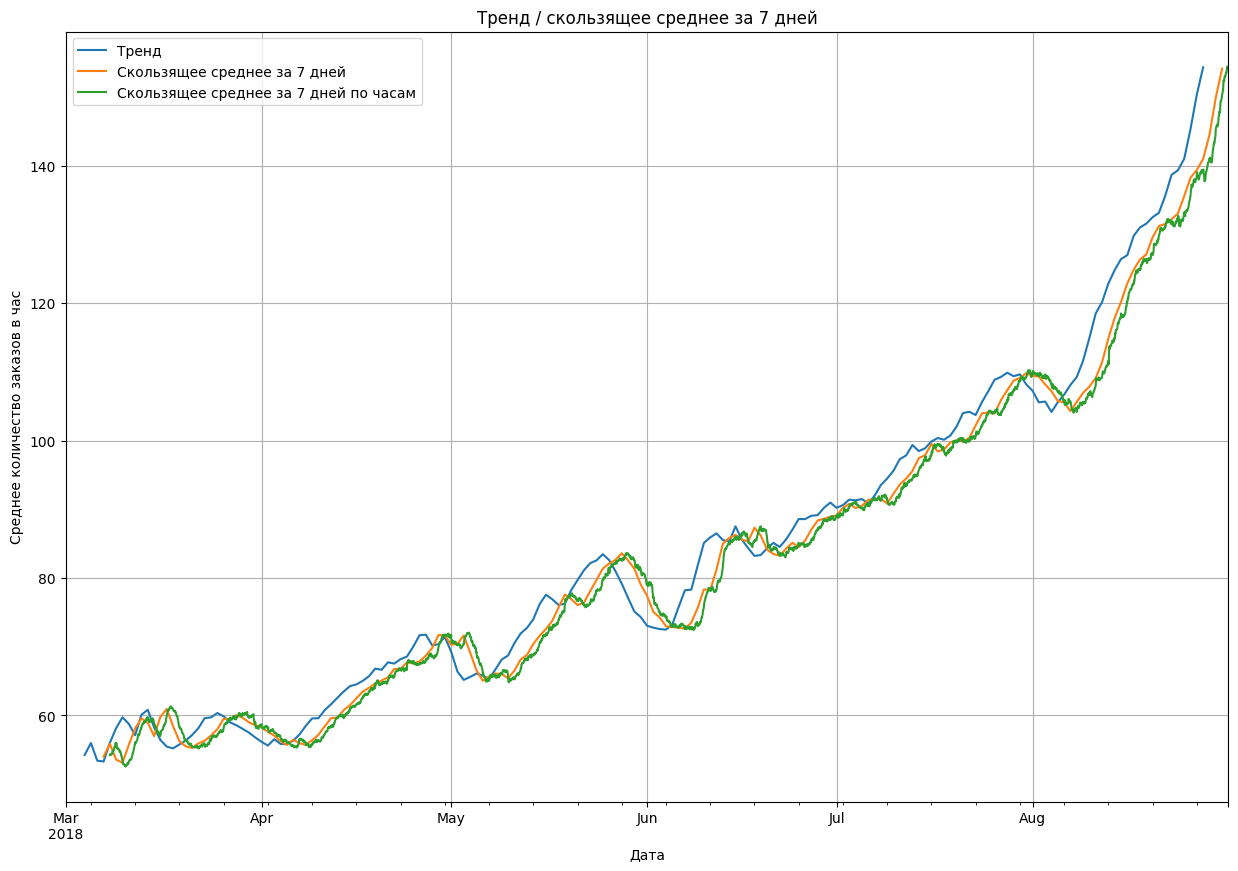

In [13]:
decomposed.trend.plot(ax=plt.gca())
data.shift(1).resample('1D').mean().rolling(7).mean().plot(ax=plt.gca())
data.shift(1).rolling(24*7).mean().plot(ax=plt.gca())
plt.title('Тренд / скользящее среднее за 7 дней')
plt.ylabel('Среднее количество заказов в час')
plt.xlabel('Дата')
plt.legend(['Тренд', 'Скользящее среднее за 7 дней', 'Скользящее среднее за 7 дней по часам'])
plt.grid(True)

Линии во многом совпадают с разницей смещения на 7 дней. Рекомендуется использовать значение тренда при создании признаков.

Однако так как данные тренда могут включать в себя будущие предсказания для создания признака тренда будем использовать среднее скользящее за неделю.

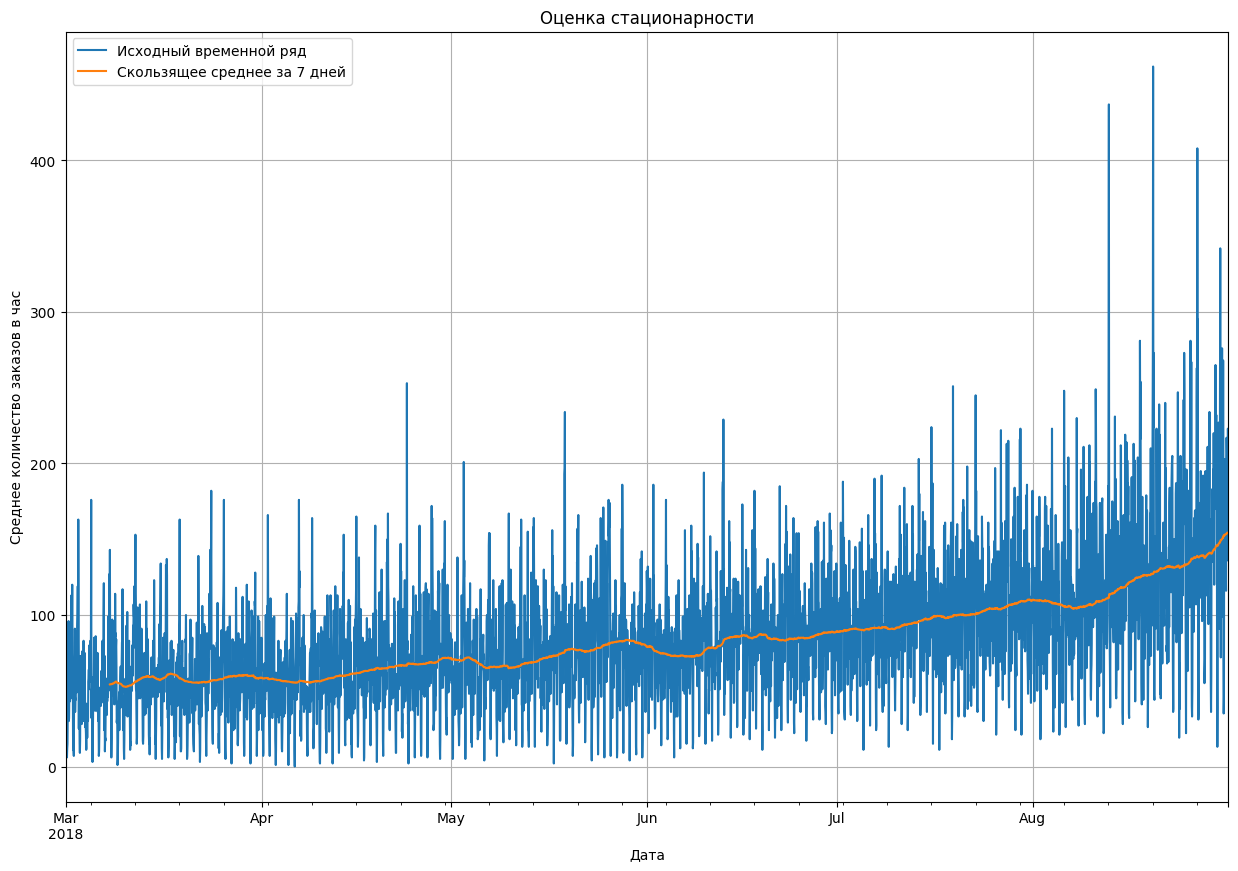

In [14]:
data.plot(ax=plt.gca())
data.shift(1).rolling(24*7).mean().plot(ax=plt.gca())
plt.title('Оценка стационарности')
plt.ylabel('Среднее количество заказов в час')
plt.xlabel('Дата')
plt.legend(['Исходный временной ряд', 'Скользящее среднее за 7 дней'])
plt.grid(True)

Изучая стационарность ряда, сравнили его со средним сглаженным за 7 дней. По представленному графику можно сказать, **что среднее и стандартное отклонение ряда** к концу августа **растёт**, следовательно **ряд нестационарный**. Ввиду этого при оценке модели стоит особо внимательно обращать внимание на более поздние предсказания. Для этого необходимо ввести веса в оценку моделей на кросс-валидации.

Опишем функцию создания признаков:

In [15]:
def help_with_features(data, num_of_shifts, wize_of_rolling):
    # создадим признак определяющий день недели
    data['dayofweek'] = data.index.dayofweek
    # создадим признак определяющий час
    data['hour'] = data.index.hour
    # создадим признак определяющий общий тренд с отставанием на один шаг, чтобы издежать включения искомого значения
    data['trend'] = data['num_orders'].shift(1).rolling(24*7).mean()
    data['trend'].fillna(data['num_orders'].shift(1).rolling(wize_of_rolling).mean(), inplace=True)
    # создадим несколько признаков прошлых измерений используя цикл и смещение данных
    for i in range(num_of_shifts):
        data['lag_' + str(i+1)] = data['num_orders'].shift(i+1)
    # создадим признак скользящего среднего с отставанием на один шаг, чтобы издежать включения искомого значения
    data['rolling_mean'] = data['num_orders'].shift(1).rolling(wize_of_rolling).mean()
    # удалим строки с отсутствующими признаками
    return data.dropna()

In [16]:
data_new = help_with_features(data, 7, 7)

## Обучение

Опишем необходимые константы

In [17]:
STATE=12345

Разобьём данные на целевой признак и определяющие

In [18]:
features = data_new.drop('num_orders', axis=1)
target = data_new['num_orders']

Выделим обучающую и тестовую выборки. Учитывая особенность временных рядов, разобъём без смешения.

***Тестовая выборка находится в конце временного ряда.***

In [19]:
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)

Так как из-за особенности временных рядов нельзя использовать стандартную кросс-валидацию и посик по сетке параметров напишем функции для обучения и оценки моделей.

Используя описанные функции оценим 3 модели:
 * Линейной регресии
 * Случайного леса
 * CatBoost

In [20]:
params = {}

CVmodelLR = GridSearchCV(LinearRegression(fit_intercept=False, positive=True), param_grid=params, scoring='neg_mean_squared_error', n_jobs=-1, cv=TimeSeriesSplit(n_splits=5))
CVmodelLR.fit(features_train, target_train)
(CVmodelLR.best_score_*-1)**0.5

31.9076376529053

In [21]:
params = {
    'n_estimators': [225, 250, 275],
    'max_depth': [None, 3, 5, 7]
}

CVmodelRF = GridSearchCV(RandomForestRegressor(random_state=STATE), param_grid=params, scoring='neg_mean_squared_error', n_jobs=-1, cv=TimeSeriesSplit(n_splits=5))
CVmodelRF.fit(features_train, target_train)
print('best result =',(CVmodelRF.best_score_*-1)**0.5)
print('best params =',CVmodelRF.best_params_)

best result = 25.271791826941342
best params = {'max_depth': None, 'n_estimators': 275}


In [27]:
params = {
    'iterations': [750, 800, 850],
    'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS']
}

CVmodelCB = GridSearchCV(CatBoostRegressor(verbose=0, random_state=STATE), param_grid=params, scoring='neg_mean_squared_error', n_jobs=-1, cv=TimeSeriesSplit(n_splits=5))
CVmodelCB.fit(features_train, target_train)
print('best result =',(CVmodelCB.best_score_*-1)**0.5)
print('best params =',CVmodelCB.best_params_)

best result = 26.1094574449448
best params = {'bootstrap_type': 'Bayesian', 'iterations': 750}


По результатам подбора гиперпараметров и оценке ***модель случайного леса показала себя лучше остальных моделей*** и может быть выбрана для оценки качества на тестовой выборке.

## Тестирование

In [28]:
predictions_RF = CVmodelRF.predict(features_test)
print('Предсказания лучшей модели:', mean_squared_error(target_test, predictions_RF)**0.5)

Предсказания лучшей модели: 44.691176640657304


In [29]:
const_model = DummyRegressor(strategy='mean')
const_model.fit(features_train, target_train)
print('Предсказания константной модели:', mean_squared_error(target_test, const_model.predict(features_test))**0.5)

Предсказания константной модели: 84.80263773864422


Модель случайного леса прошла оценку на тестовой выборке и показала результат - ***метрика RMSE = 44.69***, что меньше требуемых 48. Так же модель прошла проверку на адекватность, имея почти в двое меньшее значение метрики чем у константной модели. Это означает, что модель прошла проверку и может быть рекомендована для использования.

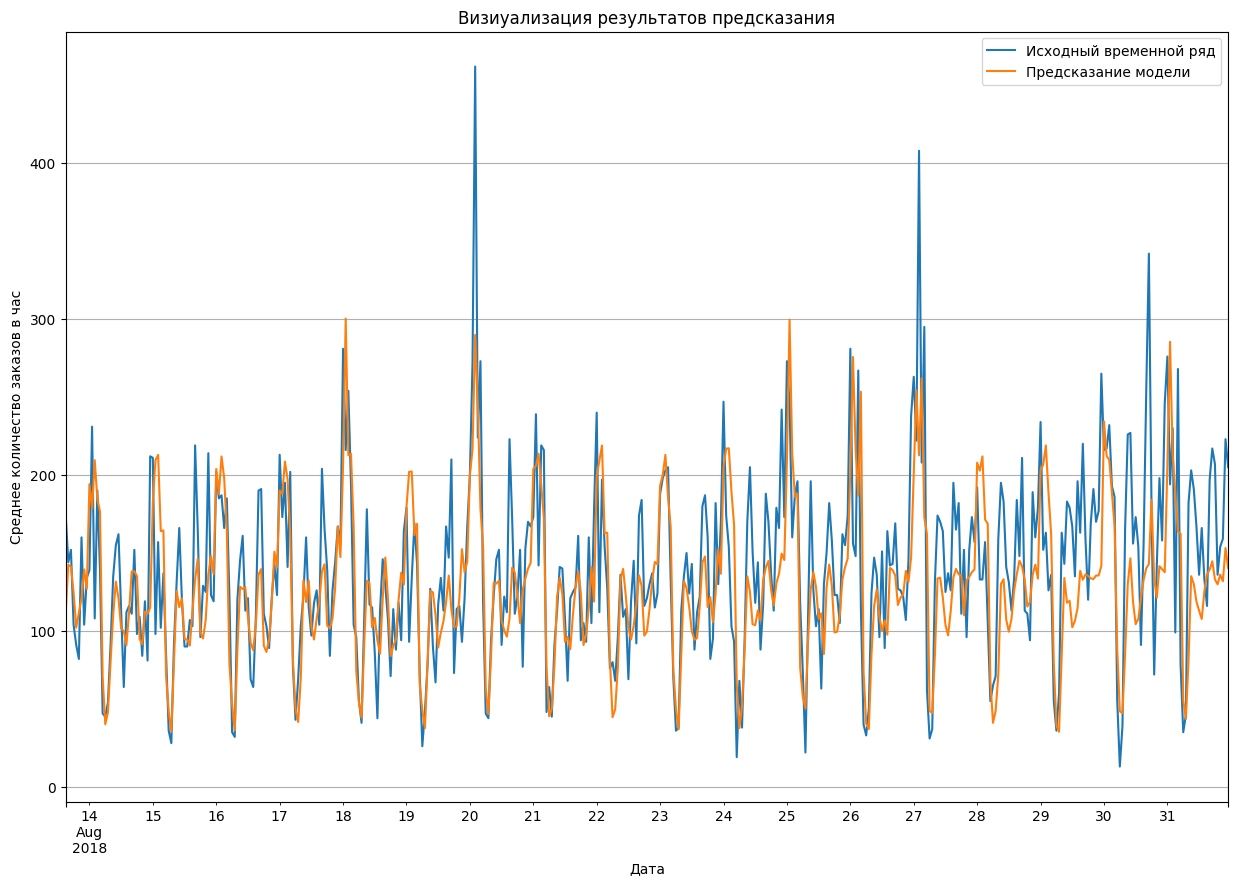

In [30]:
target_test.plot(ax=plt.gca())
pd.Series(predictions_RF, index=target_test.index).plot(ax=plt.gca())
plt.title('Визиуализация результатов предсказания')
plt.ylabel('Среднее количество заказов в час')
plt.xlabel('Дата')
plt.legend(['Исходный временной ряд', 'Предсказание модели'])
plt.grid(True)

Заметно что модель хуже угадывает пики, но хорошо предсказывает общую тенденцию роста или падения заказов. Чем дальше от исходных данных тем хуже предсказывает модель. Из-а особенности нестационарных временных рядов, предсказания на более долгий срок дают большую погрешность. Поэтому модель может быть рекомендована к использованию, однако с ограничением на максимальную дальность предсказаний.

## Общий вывод

В ходе работы был проанализированы данные о количестве заказов такси в аэропортах:
* Были выявлены период измерения данных, диапазон ряда, общие тенденции временного ряда.
* Обнаружены тенденция и сезонности ряда, выявлены их природа и закономерности.
* Изучена нестационарность ряда и выданы рекомендации связанные с ней.
* Предложена функция создания признаков для моделей и преведено объяснение их выбора
* Описаны функции подбора гиперпараметров и кросс-валидации моделей
* Предложены и обучены три модели
* Проведено сравнение моделей и выявлена лучшая среди всех
* Проведены оценка лучшей модели на адекватность и её метрики на тестовой выборке
* Выданны рекомендации к использованию модели